## Introduction to machine learning with TensorFlow

This notebook is intended to be run in a local Python environment with access to the [TensorFlow](https://www.tensorflow.org/) package and the [UCI repository of machine learning data](https://archive.ics.uci.edu/).

In [1]:
from modules.tensorflow_functions import *
from ucimlrepo import fetch_ucirepo

### Data prepration

We are using the [abalone mollusc dataset](https://archive.ics.uci.edu/dataset/1/abalone) from the UCI ML dataset repository:

In [2]:
abalones = fetch_ucirepo(id=1)

abalones_df = abalones.data.original

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The dataset comes with the variables already split into features and labels, which we can access with modules installed with the UCI ML dataset repository:

In [3]:
# Features:
abalones_x = abalones.data.features

# Labels:
abalones_y = abalones.data.targets

print("The features of this dataset are:\n")
for col in abalones_x.columns: print(col)

print("\nThe labels of this dataset are:\n")
for col in abalones_y.columns: print(col)

The features of this dataset are:

Sex
Length
Diameter
Height
Whole_weight
Shucked_weight
Viscera_weight
Shell_weight

The labels of this dataset are:

Rings


The machine learning task is to use some combination of the sex, length, diameter, height and weights (features) of an abalone mollusc to predict its age (label). According to the online metadata, age is approximated by the number of shell rings plus 1.5. We will define the age variable now:

In [4]:
abalones_df["Age"] = abalones_df["Rings"] + 1.5

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


We can see our feature set includes the variable `Sex`, which is a categorical variable. We will recode this into dummy variables:

In [5]:
encoded_sex = pd.get_dummies(abalones_df["Sex"], prefix = "Sex", dtype = int)

abalones_df = pd.concat([abalones_df, encoded_sex], axis = 1)

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0,1,0


### Creating a model with a single feature

We will use functions defined in [tensorflow_functions.py](modules/tensorflow_functions.py) to build and train a linear regression model on the abalone DataFrame.

The machine learning model will depend on three hyperparameters:

- [Learning rate](https://developers.google.com/machine-learning/glossary/#learning-rate)
- [Epochs](https://developers.google.com/machine-learning/glossary/#epoch)
- [Batch size](https://developers.google.com/machine-learning/glossary/#batch_size)

It will also depend on the feature we select to predict the label, `Age`. We can first show a correlation matrix to guide our selection of feature:

In [6]:
abalones_df.corr(numeric_only=True)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720,0.556720,0.309666,-0.551465,0.236543
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660,0.574660,0.318626,-0.564315,0.240376
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467,0.557467,0.298421,-0.518552,0.215459
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390,0.540390,0.299741,-0.557592,0.252038
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884,0.420884,0.263991,-0.521842,0.251793
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819,0.503819,0.308444,-0.556081,0.242194
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574,0.627574,0.306319,-0.546953,0.235391
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000,0.250279,-0.436063,0.181831
Age,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000,0.250279,-0.436063,0.181831
Sex_F,0.309666,0.318626,0.298421,0.299741,0.263991,0.308444,0.306319,0.250279,0.250279,1.000000,-0.464298,-0.512528


`Shell_weight` is the feature that is most strongly correlated with our label, `Age`, so we will use it to train the model.


Epoch 1/30

42/42 [==============================] - 0s 914us/step - loss: 138.7335 - root_mean_squared_error: 11.7785
Epoch 2/30
42/42 [==============================] - 0s 906us/step - loss: 126.6784 - root_mean_squared_error: 11.2552
Epoch 3/30
42/42 [==============================] - 0s 997us/step - loss: 115.6714 - root_mean_squared_error: 10.7551
Epoch 4/30
42/42 [==============================] - 0s 875us/step - loss: 105.1476 - root_mean_squared_error: 10.2541
Epoch 5/30
42/42 [==============================] - 0s 1ms/step - loss: 95.1835 - root_mean_squared_error: 9.7562
Epoch 6/30
42/42 [==============================] - 0s 854us/step - loss: 85.7571 - root_mean_squared_error: 9.2605
Epoch 7/30
42/42 [==============================] - 0s 947us/step - loss: 76.8462 - root_mean_squared_error: 8.7662
Epoch 8/30
42/42 [==============================] - 0s 953us/step - loss: 68.5084 - root_mean_squared_error: 8.2770
Epoch 9/30
42/42 [==============================] - 0s 960us/ste

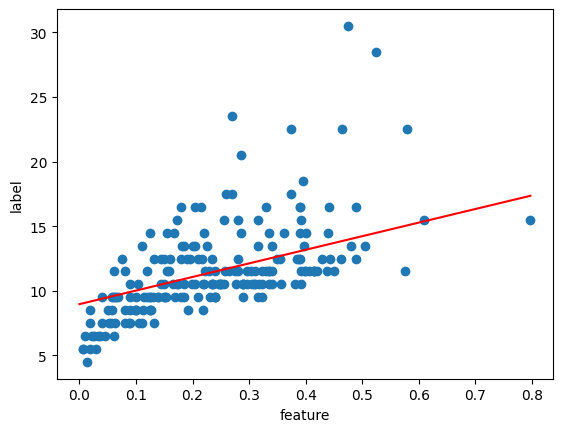

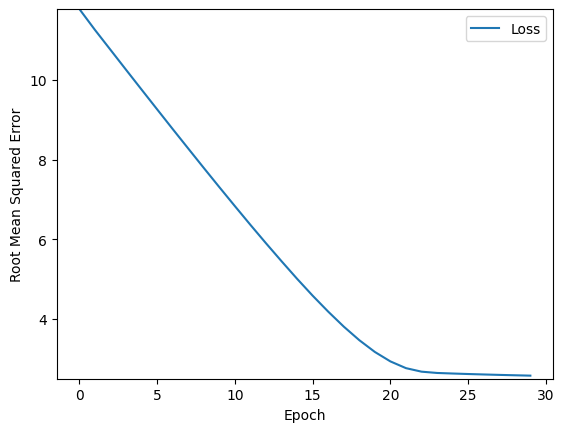

In [7]:
# Define hyperparameters
model_learning_rate = 0.01
model_epochs = 30
model_batch_size = 100

# Set label and features
model_label = "Age"
model_feature = "Shell_weight"

# Build model
base_model = build_lr_model(learning_rate = model_learning_rate)

# Train model
weight, bias, epochs, rmse = train_model(
    model = base_model,
    df = abalones_df,
    feature = model_feature,
    label = model_label,
    epochs = model_epochs,
    batch_size = model_batch_size
)

# Plot the model
plot_the_model(
    df = abalones_df,
    trained_weight = weight,
    trained_bias = bias,
    feature = model_feature,
    label = model_label
)
plot_the_loss_curve(epochs, rmse)

We can see that with the given hyperparmaters and feature, the loss function converges to a RMSE of approximately 2.5. Now that we have trained the model, we can use it to predict the age of an abalone mollusc given its shell weight.

In [8]:
predict_from_random(base_model, abalones_df, "Shell_weight", 10)

,Generated feature data,Predicted label
0,0.194177,11.011996
1,0.409643,13.277314
2,0.369233,12.852456
3,0.329703,12.436854
4,0.373533,12.897662
5,0.145666,10.501982
6,0.348875,12.638428
7,0.271428,11.824181
8,0.077135,9.781474
9,0.344375,12.591112


### Training data, validation data, and test data

In the above example, we used the entire dataset to train the model. We were able to do this because the dataset is quite small, but in real-world applications of machine learning, the data we would like to use to predict useful statistics will often be enormous or constantly growing (for example, customer data from a service like Netflix). For most machine learning applications, the computing costs of training a model on a full-size dataset are prohibitive. Instead, the data is partitioned to create a subset of the data to train the model - the training set.

To evaluate the performance of the trained model, it is vitally important that none of the records from the training set are used to evaluate the model. Instead, two extra partitions are used - the validation set and the test set, which are both unique from eachother and both unique from the training set.

<div>
<img src="https://developers.google.com/static/machine-learning/crash-course/images/WorkflowWithValidationSet.svg" width="1000">
</div>

We will create a training set using a random sample of the base abalones dataset. The size of the training set is arbritrarily set to be 20% of the base dataset.

In [9]:
abalones_train_df = abalones_df.sample(frac=0.2)

abalones_train_df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
979,M,0.535,0.435,0.140,0.8740,0.3735,0.2290,0.2195,8,9.5,0,0,1
3712,F,0.705,0.530,0.170,1.5640,0.6120,0.3940,0.4400,10,11.5,1,0,0
2142,I,0.460,0.350,0.110,0.3945,0.1685,0.0865,0.1250,9,10.5,0,1,0
4090,M,0.615,0.475,0.205,1.3370,0.5995,0.2815,0.3700,11,12.5,0,0,1
71,F,0.400,0.320,0.110,0.3530,0.1405,0.0985,0.1000,8,9.5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,I,0.395,0.310,0.095,0.3130,0.1310,0.0720,0.0930,7,8.5,0,1,0
1394,M,0.640,0.565,0.230,1.5210,0.6440,0.3720,0.4060,15,16.5,0,0,1
3005,M,0.680,0.540,0.210,1.7885,0.8345,0.4080,0.4370,13,14.5,0,0,1
866,M,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.3250,9,10.5,0,0,1


We will create a test set using a random sample of a subset of the base abalones dataset which has had all the records present in the training set removed from it. We will arbritrarily set the size of this test set to be 50% of the subsetted base dataset.

In [10]:
abalones_test_df = abalones_df.drop(abalones_train_df.index).sample(frac=0.5)

abalones_test_df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
303,M,0.360,0.270,0.100,0.2170,0.0885,0.0495,0.0715,6,7.5,0,0,1
3919,I,0.565,0.430,0.135,0.8545,0.3210,0.1775,0.2750,11,12.5,0,1,0
3672,F,0.595,0.440,0.135,0.9640,0.5005,0.1715,0.2575,10,11.5,1,0,0
3902,I,0.160,0.120,0.020,0.0180,0.0075,0.0045,0.0050,4,5.5,0,1,0
599,F,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.3350,16,17.5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,F,0.605,0.490,0.150,1.1345,0.4305,0.2525,0.3500,10,11.5,1,0,0
174,I,0.235,0.160,0.040,0.0480,0.0185,0.0180,0.0150,5,6.5,0,1,0
1684,I,0.620,0.470,0.140,0.8565,0.3595,0.1600,0.2950,9,10.5,0,1,0
801,M,0.450,0.335,0.125,0.3490,0.1190,0.1055,0.1150,10,11.5,0,0,1


Before continuing we will check the intersection of the training set and test set. No records from the training set should be in the test set, so the intersection should be empty.

In [11]:
if(len(abalones_train_df.merge(abalones_test_df)) == 0):
    print("Intersection is empty!")

abalones_train_df.merge(abalones_test_df)

Intersection is empty!


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M


Our train and test sets are now defined. When we build and train the model, we can define the validation set through a partition of the original training set into a partition set and a new training set. The size of this partition is adjusted using the parameter `validation_split`.

Epoch 1/30
48/48 [==============================] - 0s 3ms/step - loss: 120.6810 - root_mean_squared_error: 10.9855 - val_loss: 121.4261 - val_root_mean_squared_error: 11.0194
Epoch 2/30
48/48 [==============================] - 0s 1ms/step - loss: 108.2240 - root_mean_squared_error: 10.4031 - val_loss: 109.2063 - val_root_mean_squared_error: 10.4502
Epoch 3/30
48/48 [==============================] - 0s 1ms/step - loss: 96.6922 - root_mean_squared_error: 9.8332 - val_loss: 97.5317 - val_root_mean_squared_error: 9.8758
Epoch 4/30
48/48 [==============================] - 0s 1ms/step - loss: 85.9324 - root_mean_squared_error: 9.2700 - val_loss: 86.8045 - val_root_mean_squared_error: 9.3169
Epoch 5/30
48/48 [==============================] - 0s 1ms/step - loss: 75.9285 - root_mean_squared_error: 8.7137 - val_loss: 76.6565 - val_root_mean_squared_error: 8.7554
Epoch 6/30
48/48 [==============================] - 0s 1ms/step - loss: 66.5723 - root_mean_squared_error: 8.1592 - val_loss: 67.260

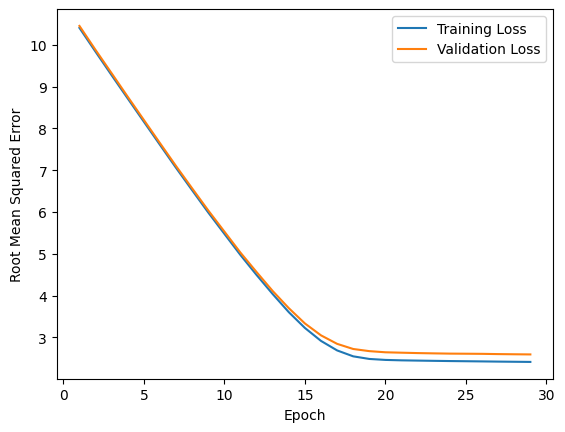

In [12]:
# Adjust the hyperparameters from the previous example - reduce the batch size as training set is now substantially smaller
model_learning_rate = 0.01
model_epochs = 30
model_batch_size = 14

# Partition training set into a validation set and a new training set
validation_split = 0.2

# Use the same feature and label from the previous example
model_label = "Age"
model_feature = "Shell_weight"

# Build model
base_model = build_lr_model(learning_rate = model_learning_rate)

# Train model - the order of the training set is being shuffled before partitioning to avoid bias in the validation set
weight, bias, epochs, rmse, history = train_model_with_validation(
    model = base_model,
    df = abalones_train_df.reindex(np.random.permutation(abalones_train_df.index)),
    feature = model_feature,
    label = model_label,
    epochs = model_epochs,
    batch_size = model_batch_size,
    validation_split = validation_split
)

plot_the_loss_curve_with_validation(epochs, 
                                    history["root_mean_squared_error"],
                                    history["val_root_mean_squared_error"])

The loss curve of the model on the validation set and on the training set are both shown above. As the loss curves both converge to a similar RMSE, this is a good sign the model is working as expected. The next step is then to evaluate the trained model against the test set:

In [13]:
results = base_model.evaluate(abalones_test_df["Shell_weight"], # Test set feature
                              abalones_test_df["Age"],          # Test set label
                              batch_size = model_batch_size)

120/120 [==============================] - 0s 749us/step - loss: 6.6515 - root_mean_squared_error: 2.5791


Ideally, the final model RMSE for the training set, validation set, and test set should all be similar.